# Word embeddings

The previous analyses have shown that fake news tends to use consistently inflammatory and subjective vocabulary, and tends to cover issues that may incite controversy.

Let's drill down to the word level and look for connotations among words used in both fake and real news. This could reveal underlying biases that shape how certain words like `election` or `president` are perceived.

1. [Load data](#Load-data)
2. [Train embeddings](#Train-embedding-models)
3. [Nearest neighbors](#Look-at-nearest-neighbors)
4. [Different neighbors](#Find-words-with-different-neighbors)
5. [Exploration](#Exploration)

### Load data

In [ ]:
# NOTE: only run if you don't have data/ in Files
!wget https://bitbucket.org/istewart6/core_tutorial_2020/raw/36e69f9d777319ae2cc94354cf57bd01f3e080b3/data.zip . ; unzip data.zip

--2020-12-09 19:49:23--  https://bitbucket.org/istewart6/core_tutorial_2020/raw/9feab1699d48005d9631f277771d91b2075d1256/data.zip
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230901661 (220M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 220.20M  41.2MB/s    in 5.5s    

2020-12-09 19:49:36 (39.9 MB/s) - ‘data.zip’ saved [230901661/230901661]

--2020-12-09 19:49:36--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-12-09 19:49:36--
Total wall clock time: 13s
Downloaded: 1 files, 220M in 5.5s (39.9 MB/s)
Archive:  data.zip
   creating: data/
   creating: data/fakeNewsDatasets/
  inflating: data/fakeNewsDatasets/fake_news_small.tsv  
  inflating: data/fakeNewsDatase

In [ ]:
!pip install stop_words
!pip install glove-python

In [ ]:
## data = fake news challenge
import pandas as pd
fake_news_article_data = pd.read_csv('data/fake_news_challenge/Fake.csv', sep=',', index_col=False)
real_news_article_data = pd.read_csv('data/fake_news_challenge/True.csv', sep=',', index_col=False)
display(fake_news_article_data.head())

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
# ## clean data
from nltk.tokenize import PunktSentenceTokenizer, WordPunctTokenizer
sent_tokenizer = PunktSentenceTokenizer()
word_tokenizer = WordPunctTokenizer()
def get_sentence_word_tokens(text, word_tokenizer, sent_tokenizer):
    text_sents = sent_tokenizer.tokenize(text)
    text_sent_tokens = list(map(word_tokenizer.tokenize, text_sents))
    return text_sent_tokens
fake_news_sentences = fake_news_article_data.loc[:, 'text'].apply(lambda x: get_sentence_word_tokens(x, word_tokenizer, sent_tokenizer))
real_news_sentences = real_news_article_data.loc[:, 'text'].apply(lambda x: get_sentence_word_tokens(x, word_tokenizer, sent_tokenizer))
# flatten for processing
from functools import reduce
def flatten_list_data(data):
    flat_data = []
    for x in data:
        flat_data.extend(x)
    return flat_data
fake_news_sentences = flatten_list_data(fake_news_sentences)
real_news_sentences = flatten_list_data(real_news_sentences)

### Train embedding models
Let's first train the word embedding models on the full data.

In [ ]:
## train word2vec embeddings
from gensim.models.word2vec import Word2Vec
def train_word2vec_model(text_sents, model_out_file):
    dim = 50
    alpha = 0.025
    window = 5
    min_count = 5
    model = Word2Vec(sentences=text_sents, size=dim, alpha=alpha, window=window, min_count=min_count, seed=123)
#     model.build_vocab(text_sents)
    model.save(model_out_file)
fake_news_word2vec_model_out_file = 'data/fake_news_challenge/fake_news_word2vec_embed.model'
real_news_word2vec_model_out_file = 'data/fake_news_challenge/real_news_word2vec_embed.model'
## training takes ~ 10 mins on Colab
# SKIP these steps during tutorial to save time; use pre-trained model
# train_word2vec_model(fake_news_sentences, fake_news_word2vec_model_out_file)
# train_word2vec_model(real_news_sentences, real_news_word2vec_model_out_file)

In [ ]:
## load from file
fake_news_word2vec_embed_model = Word2Vec.load(fake_news_word2vec_model_out_file)
real_news_word2vec_embed_model = Word2Vec.load(real_news_word2vec_model_out_file)

In [ ]:
## train Glove embeddings
from glove import Glove, Corpus
def fit_glove_model(text_sents, model_out_file):
    dim = 50
    learning_rate = 0.05
    alpha = 0.025
    random_state = 123
    train_epochs = 100
    num_threads = 4
    window = 5
    glove_corpus = Corpus()
    glove_corpus.fit(text_sents, window=window)
    glove_embed_model = Glove(no_components=dim, learning_rate=learning_rate, 
                              alpha=alpha, random_state=random_state)
    # note: this takes ~ 5 minutes with 4 threads on a server
    glove_embed_model.fit(glove_corpus.matrix, epochs=train_epochs,
                          no_threads=num_threads, verbose=True)
    glove_embed_model.add_dictionary(glove_corpus.dictionary)
    glove_embed_model.save(model_out_file)
fake_news_glove_model_out_file = 'data/fake_news_challenge/fake_news_glove_embed.model'
real_news_glove_model_out_file = 'data/fake_news_challenge/real_news_glove_embed.model'
## skipping these steps to save time during tutorial
# fit_glove_model(fake_news_sentences, fake_news_glove_model_out_file)
# fit_glove_model(real_news_sentences, real_news_glove_model_out_file)

Performing 100 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Performing 100 training epochs with 4 threads
Epoch 0
Epoch 1
Ep

In [ ]:
## reload models after training
fake_news_glove_embed_model = Glove.load(fake_news_glove_model_out_file)
real_news_glove_embed_model = Glove.load(real_news_glove_model_out_file)

In [ ]:
# !rm data.zip
!zip -r data.zip data/

  adding: data/ (stored 0%)
  adding: data/fakeNewsDatasets/ (stored 0%)
  adding: data/fakeNewsDatasets/fake_news_small.tsv (deflated 63%)
  adding: data/fakeNewsDatasets/real_news_small.tsv (deflated 58%)
  adding: data/fake_news_challenge/ (stored 0%)
  adding: data/fake_news_challenge/fake_news_glove_embed.model (deflated 6%)
  adding: data/fake_news_challenge/real_news_word2vec_embed.model (deflated 30%)
  adding: data/fake_news_challenge/Fake.csv (deflated 62%)
  adding: data/fake_news_challenge/fake_news_word2vec_embed.model (deflated 29%)
  adding: data/fake_news_challenge/True.csv (deflated 65%)
  adding: data/fake_news_challenge/real_news_glove_embed.model (deflated 6%)


### Look at nearest neighbors

Let's start out by looking at the nearest neighbors for some test words. 

We'll get the test words by filtering from the most frequent words.

In [ ]:
from collections import Counter
from stop_words import get_stop_words
import pandas as pd
pd.set_option('display.max_rows', 100)
news_word_counter = Counter()
for sent_i in fake_news_sentences:
    news_word_counter.update(sent_i)
for sent_i in real_news_sentences:
    news_word_counter.update(sent_i)
news_word_counts = pd.Series(dict(news_word_counter)).sort_values(inplace=False, ascending=False)
en_stops = set(get_stop_words('en')) & set(news_word_counts.index)
news_word_counts.drop(en_stops, inplace=True)
display(news_word_counts.head(100))

.                 899948
,                 872906
s                 231123
-                 191679
Trump             132996
said              132673
The               115553
’                  70098
:                  63415
)                  63128
I                  62061
(                  57607
U                  54124
“                  53931
t                  53069
S                  51453
will               48561
people             39640
President          36123
one                32627
also               30519
It                 29705
Reuters            29343
Clinton            28556
Donald             28066
Obama              28035
?                  27492
government         26786
can                26401
He                 26344
Republican         25450
House              25418
In                 25292
year               24425
,”                 24296
/                  23695
told               23330
United             22860
just               22835
We                 22082


In [ ]:
test_words = ['Trump', 'President', 'election', 'Republicans', 'Democratic']

In [ ]:
## test word2vec first
N_neighbors = 10
for test_word_i in test_words:
    print(f'testing word = {test_word_i}')
    print(f'\tfake news neighbors')
    print(fake_news_word2vec_embed_model.wv.most_similar(test_word_i, topn=N_neighbors))
    print(f'\treal news neighbors')
    print(real_news_word2vec_embed_model.wv.most_similar(test_word_i, topn=N_neighbors))

testing word = Trump
	fake news neighbors
[('Cruz', 0.7542868852615356), ('Obama', 0.7326431274414062), ('he', 0.6627222299575806), ('Rubio', 0.6566429138183594), ('trump', 0.6353479623794556), ('GOP', 0.6161357164382935), ('him', 0.6154471039772034), ('He', 0.6065627336502075), ('Putin', 0.5974994897842407), ('Bush', 0.5890234112739563)]
	real news neighbors
[('him', 0.6888852119445801), ('Obama', 0.6868149638175964), ('Macron', 0.6779283285140991), ('Cruz', 0.6577001214027405), ('Rubio', 0.6564674973487854), ('Clinton', 0.6557707786560059), ('Abe', 0.651238739490509), ('he', 0.6333320140838623), ('Pence', 0.6211468577384949), ('Tillerson', 0.6183730363845825)]
testing word = President
	fake news neighbors
[('president', 0.8004584312438965), ('Barack', 0.7969117760658264), ('administration', 0.7702555656433105), ('presidency', 0.7402648329734802), ('Administration', 0.7270553112030029), ('Michelle', 0.616836667060852), ('nominee', 0.6052952408790588), ('regime', 0.5850890874862671), (

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


For `word2vec`:
- `Trump` is associated with almost exclusively Republican politicians (and Putin) in fake news and with a mix of international politicians in real news
- `President` is associated more with U.S. politics in fake news and more with international politicians in real news
- `Democratic` are associated more with U.S. politics in fake news and more with general political parties in real news

In [ ]:
## test Glove embeddings
N_neighbors = 10
for test_word_i in test_words:
    print(f'testing word = {test_word_i}')
    print(f'\tfake news neighbors')
    print(fake_news_glove_embed_model.most_similar(test_word_i, number=N_neighbors))
    print(f'\treal news neighbors')
    print(real_news_glove_embed_model.most_similar(test_word_i, number=N_neighbors))

testing word = Trump
	fake news neighbors
[('Donald', 0.8995104048828402), ('he', 0.7510152023913843), ('President', 0.7289551160683528), ('elect', 0.7018952339996948), ('his', 0.6894683958666277), ('him', 0.6590607131669851), ('supporter', 0.650652397522237), ('Obama', 0.6459602087651001), ('presidency', 0.6456801048266373)]
	real news neighbors
[('Donald', 0.8999952077484253), ('Obama', 0.740171056813851), ('Clinton', 0.7259076263176928), ('he', 0.7161130616849752), ('Putin', 0.7157221029232305), ('president', 0.7005582815167459), ('administration', 0.699648394966008), ('elect', 0.6946826981167531), ('He', 0.6930951709096086)]
testing word = President
	fake news neighbors
[('Obama', 0.8787505866253105), ('president', 0.8297460406112078), ('Barack', 0.8097643017568634), ('Donald', 0.7786599002096065), ('ObamaE', 0.7675834296393814), ('administration', 0.7636917647469326), ('elect', 0.7305534045344345), ('Trump', 0.728955116068353), ('Putin', 0.6716257742337292)]
	real news neighbors
[

For `Glove`:
- `Trump` is associated with himself (and news network? `Q13FOXWATCH`) in fake news and with other presidents in real news
- `President` is associated with Trump and Obama in fake news and more with international politicians in real news
- `Democratic` is associated with U.S. party politics in both fake and real news

This qualitative analysis helps us understand that some words may indeed have significant divergence in their connotations between the different data sets, while others are more stable.

### Find words with different neighbors

Which words are the most different across the data?

We'll measure "difference" using the overlap in nearest neighbors (i.e. Jaccard similarity).

$$\text{diff(word1, word2)} = 1 - \frac{\text{neighbors(word1)} \: \cap \: \text{neighbors(word2)}}{\text{neighbors(word1)} \cup \text{neighbors(word2)}}$$

A difference of 100% means that the words have no neighbors in common, while a difference of 0% means that the words have identical neighbors.

In [ ]:
def compute_neighbor_diff(neighbors_1, neighbors_2):
    neighbor_intersect = set(neighbors_1) & set(neighbors_2)
    neighbor_union = set(neighbors_1) | set(neighbors_2)
    neighbor_diff = 1 - len(neighbor_intersect) / len(neighbor_union)
    return neighbor_diff
def compute_neighbor_diff_model(word, model_1, model_2, N_neighbor, model_type='word2vec'):
    if(model_type == 'word2vec'):
        neighbors_1, neighbor_scores_1 = zip(*model_1.wv.most_similar(word, topn=N_neighbor))
        neighbors_2, neighbor_scores_2 = zip(*model_2.wv.most_similar(word, topn=N_neighbor))
    elif(model_type == 'glove'):
        neighbors_1, neighbor_scores_1 = zip(*model_1.most_similar(word, number=N_neighbor))
        neighbors_2, neighbor_scores_2 = zip(*model_2.most_similar(word, number=N_neighbor))
    neighbor_diff = compute_neighbor_diff(neighbors_1, neighbors_2)
    return neighbor_diff

In [ ]:
# get shared vocabulary
shared_word2vec_vocab = list(set(fake_news_word2vec_embed_model.wv.vocab.keys()) & set(real_news_word2vec_embed_model.wv.vocab.keys()))
print(f'{len(shared_word2vec_vocab)} words in word2vec vocab')
# compute neighbor differences for all valid words
model_type = 'word2vec'
N_neighbor = 10
fake_vs_real_word2vec_neighbor_diffs = list(map(lambda x: compute_neighbor_diff_model(x, fake_news_word2vec_embed_model, real_news_word2vec_embed_model, N_neighbor, model_type=model_type), shared_word2vec_vocab))
# add vocabulary as index
fake_vs_real_word2vec_neighbor_diffs = pd.Series(fake_vs_real_word2vec_neighbor_diffs, index=shared_word2vec_vocab)
fake_vs_real_word2vec_neighbor_diffs.sort_values(inplace=True, ascending=False)

23922 words in word2vec vocab


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
top_k = 20
print('words with most neighbor difference')
print(fake_vs_real_word2vec_neighbor_diffs.head(top_k))
print('words with most neighbor similarity')
print(fake_vs_real_word2vec_neighbor_diffs.tail(top_k))

words with most neighbor difference
swath           1.0
Missing         1.0
WIN             1.0
Policies        1.0
Vasquez         1.0
transitioned    1.0
wheelchairs     1.0
reprieve        1.0
testing         1.0
Township        1.0
Patriot         1.0
Players         1.0
rough           1.0
facade          1.0
referral        1.0
106             1.0
Nike            1.0
psyche          1.0
WHO             1.0
tentatively     1.0
dtype: float64
words with most neighbor similarity
March        0.181818
aside        0.181818
April        0.181818
his          0.181818
February     0.181818
June         0.181818
July         0.181818
anyone       0.181818
September    0.181818
December     0.181818
Tuesday      0.181818
cannot       0.181818
November     0.181818
two          0.181818
January      0.181818
He           0.181818
Thursday     0.181818
Friday       0.181818
Wednesday    0.181818
Monday       0.000000
dtype: float64


The words with the biggest neighbor differences don't seem to be super informative and may reflect topical differences (e.g. fake news tends to discuss `Patriot` more often and therefore has more consistent nearest neighbors).

What if we restrict to the most frequent words?

In [ ]:
# filter the word counts to include words that are in the shared vocab
word2vec_vocab_news_word_counts = news_word_counts.loc[(news_word_counts.index & set(shared_word2vec_vocab))]
word2vec_neighbor_diff_count_data = pd.concat([fake_vs_real_word2vec_neighbor_diffs, 
                                               word2vec_vocab_news_word_counts], axis=1).dropna()
word2vec_neighbor_diff_count_data.columns = ['neighbor_diff', 'count']
# sort data by difference, then frequency
word2vec_neighbor_diff_count_data.sort_values(['neighbor_diff', 'count'], inplace=True, ascending=False)
top_k = 100
display(word2vec_neighbor_diff_count_data.head(top_k))

,neighbor_diff,count
(,1.0,57607.0
U,1.0,54124.0
Donald,1.0,28066.0
/,1.0,23695.0
United,1.0,22860.0
New,1.0,13346.0
news,1.0,10343.0
via,1.0,9650.0
News,1.0,9025.0
image,1.0,8719.0


OK! This leaves us with some interesting words to investigate:

- `twitter`
- `defense`
- `gun`
- `Brexit`
- `popular`
- `People`
- `corruption`

In [ ]:
# print neighbors for all high-difference words
high_diff_words = ['twitter', 'defense', 'gun', 'Brexit', 'popular', 'People', 'corruption']
N_neighbors = 10
for word_i in high_diff_words:
    print(f'testing word = {word_i}')
    print(f'\tfake news neighbors')
    print(fake_news_word2vec_embed_model.most_similar(word_i, topn=N_neighbors))
    print(f'\treal news neighbors')
    print(real_news_word2vec_embed_model.most_similar(word_i, topn=N_neighbors))

testing word = twitter
	fake news neighbors
[('www', 0.6070612668991089), ('pic', 0.5979985594749451), ('john', 0.5946311354637146), ('hillaryclinton', 0.5928731560707092), ('??????????', 0.579643964767456), ('Neiman', 0.5753360986709595), ('en_US', 0.5644693374633789), ('sdk', 0.5569521188735962), ('WomensMarch', 0.5483077168464661), ('ConcernedStudent1950', 0.5445438623428345)]
	real news neighbors
[('microblog', 0.7688511610031128), ('crotch', 0.7561038136482239), ('Instagram', 0.7461926341056824), ('Weibo', 0.7108451128005981), ('Wheels', 0.6860888004302979), ('LinkedIn', 0.6857026219367981), ('dwelling', 0.6821672916412354), ('Meals', 0.6682783365249634), ('morals', 0.6675081253051758), ('writings', 0.6665583252906799)]
testing word = defense
	fake news neighbors
[('role', 0.6575046181678772), ('position', 0.615018367767334), ('stance', 0.5982798337936401), ('servant', 0.5973563194274902), ('chief', 0.5921223759651184), ('rejection', 0.5802915096282959), ('alliance', 0.57680302858

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


This reveals consistent connotation differences in the way that fake news articles frame common issues.

- `twitter` is associated with activity on the platform (`WomensMarch`) in fake news, and associated with other social media platforms in real news
- `defense` is associated with more general aspects of defending, and associated with government departments in real news
- `gun` is associated with different components of owning guns (`firearm`, `concealed`) in fake news, and associated with controversial issues and restrictions (`abortion`, `strict`) in real news
- `Brexit` is associated with conflict in fake news (`victory`), and associated with European politics in real news
- `popular` is associated with political polling in fake news (`margin`, `politician`), and associated with election outcomes for sub-populations (`Hispanic`, `blacks`) in real news
- `People` is associated with "national" identity (`patriots`, `liberals`) in fake news, and associated with more diverse identity (`Women`, `Black`) in real news
- `corruption` is associated with investigations into hacking (related to Clinton's emails?) in fake news, and associated with financial crime in real news

### Visualizing word embeddings
Similar to the topic models, we may find that we can explore associations between words more effectively by visualizing the word embeddings in 2-dimensional space.

Let's use Principal Components Analysis again to convert the word embeddings to 2-dimensional space.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def shrink_embeddings(embeddings):
    num_viz_components = 2
    pca_model = PCA(n_components=num_viz_components)
    mini_embeddings = pca_model.fit_transform(embeddings)
    # rescale to N(0,1)
    scaler = StandardScaler()
    mini_embeddings = scaler.fit_transform(mini_embeddings)
    return mini_embeddings
real_news_word2vec_mini_embeds = shrink_embeddings(real_news_word2vec_embed_model.wv.vectors)
fake_news_word2vec_mini_embeds = shrink_embeddings(fake_news_word2vec_embed_model.wv.vectors)
# get word to index lookup
real_news_word2vec_vocab_idx = {word : index for index, word in enumerate(real_news_word2vec_embed_model.wv.index2word)}
fake_news_word2vec_vocab_idx = {word : index for index, word in enumerate(fake_news_word2vec_embed_model.wv.index2word)}

Let's just try to plot the top-K words to keep things from getting too messy.

In [ ]:
top_k_plot_word_count = 100
top_k_plot_words = word2vec_vocab_news_word_counts.sort_values(inplace=False, ascending=False).iloc[:top_k_plot_word_count].index.tolist()
print(top_k_plot_words[:50])

['.', ',', 's', '-', 'Trump', 'said', 'The', ':', ')', 'I', '(', 'U', 't', 'S', 'will', 'people', 'President', 'one', 'also', 'It', 'Reuters', 'Clinton', 'Donald', 'Obama', '?', 'government', 'can', 'He', 'Republican', 'House', 'In', 'year', '/', 'told', 'United', 'just', 'We', 'like', 'state', 'campaign', 'time', 'A', 'election', 'two', 'president', 'States', 'last', 'But', '$', 'country']


In [ ]:
## code to plot each word as an annotated point
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
def plot_embeddings(embeddings, embedding_vocab, vocab_to_idx):
    embedding_vocab_idx = list(map(lambda x: vocab_to_idx[x], embedding_vocab))
    height, width = (10, 6)
    plot_fig = plt.figure(figsize=(height, width))
    ax = plot_fig.add_subplot(1,1,1)
    # plot invisible points to make words easier to see
    ax.scatter(embeddings[embedding_vocab_idx, 0], embeddings[embedding_vocab_idx, 1], color=(0.,0.,0.,0.))
    for i, (word_i, index_i) in enumerate(zip(embedding_vocab, embedding_vocab_idx)):
        position_i = embeddings[index_i, :]
        # make words semi-transparent for easier browsing
        ax.annotate(word_i, position_i, color=(0.,0.,0.,0.8))
    plt.show()

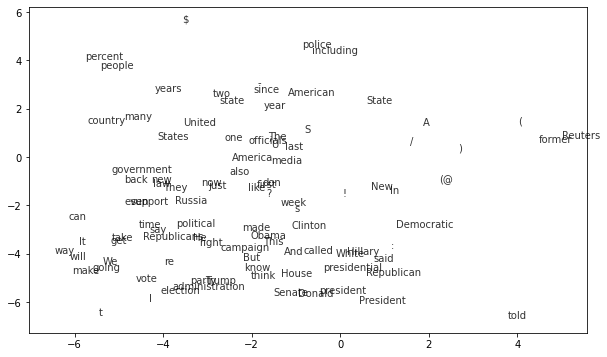

In [ ]:
# plot real news embeddings
plot_embeddings(real_news_word2vec_mini_embeds, top_k_plot_words, real_news_word2vec_vocab_idx)

In real news articles, the politicians tend to cluster together (`Obama`, `Clinton`, `Donald`) while the more America-related words form a different cluster (`American`, `United`).

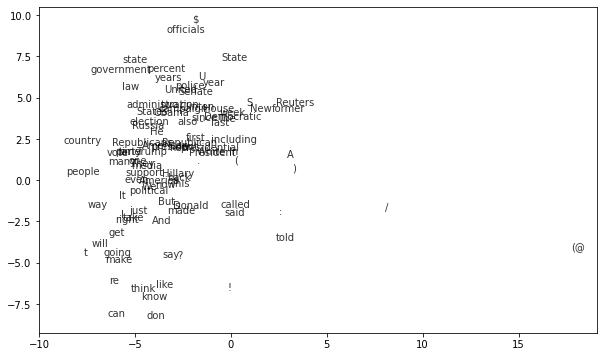

In [ ]:
# plot real news embeddings
plot_embeddings(fake_news_word2vec_mini_embeds, top_k_plot_words, fake_news_word2vec_vocab_idx)

In fake news articles, we see a much more skewed distribution. 

The politicia names no longer appear as clearly clustered (`Donald` outside of main "blob"), and some words appear more "extreme" in their use (`country`, `people`, `government`). 

The "subjective" words that we noted in the topic analysis (`think`, `know`) seem to form their own cluster as well.

### Exploration
Now it's time for you to try out some more tests with word embeddings!

- Increasing the **window size** when training embeddings can help the embeddings capture more global context (e.g. associating `tomato` with cooking details from the wider sentence context). How would this help capture divides between fake news and real news?
- One way to determine the **connotation** of a word in embedding space is to look at its proximity to positive and negative words: e.g. if `Barack` is consistently closer to words like `bad` and `terrible` than to `good` and `nice`. Can you come up with a way to test word connotations using this kind of approach, and determine whether some words have consistently better or worse connotations in fake news articles?
- Another useful aspect of word embeddings is their tendency to **cluster** words into general semantic fields, e.g. grouping all politician names near one another. Using the visualization technique from above, try to find words that (1) consistently fall into neat clusters and (2) sometimes appear outside of the expected clusters in the data. Which political and organizational words tend to be represented outside of their expected cluster, and why do you think that happens? 